In [1]:
from catinous.dataset import BatchDataset, ContinuousDataset
from catinous.dynamicmemory.DynamicMemoryModel import DynamicMemoryModel 
import catinous.dynamicmemory.DynamicMemoryModel as dmodel
import catinous.utils as cutils
import os
import pandas as pd
import argparse
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import catinous.evalfunctions as evalfu

In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/mperkonigg/.local/lib/python3.6/site-packages/m

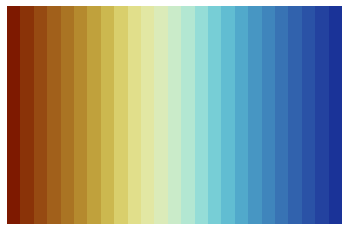

In [8]:
mapname = 'roma'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
x = np.linspace(0, 100, 25)[None, :]
plt.imshow(x, aspect='auto',cmap=colormap)
plt.axis('off')
plt.show()
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')

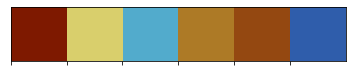

In [9]:
cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
#colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
#x = np.linspace(0, 100, 25)[None, :]
#plt.imshow(x, aspect='auto',cmap=colormap)
#plt.axis('off')
#plt.show()
colormap = ListedColormap([cm_data[0], cm_data[85],cm_data[180], cm_data[45], cm_data[20], cm_data[227]], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')
sns.palplot(sns.color_palette())

In [23]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplit.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': 'Siemens',
     'noncontinuous_steps': 500,
    'noncontinuous_train_splits': ['base', 'train'],
    'use_memory': False
}

val_dice1_Siemens = []
val_dice2_Siemens = []
val_dice3_Siemens = []
val_dice1_GE = []
val_dice1_Philips = []
val_dice1_Canon = []

for scanner in ['Siemens', 'GE', 'Philips', 'Canon', None]:
    hparams['scanner'] = scanner
    if scanner is None:
        hparams['order'] = ['Siemens', 'GE', 'Philips', 'Canon']
    #model, logs, df_cache = catsmodel.trained_model(hparams)
    expparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
    exp_name = cutils.get_expname(expparams)

    max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
    logs = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))
    
    val_dice1_Siemens.append(logs.iloc[-1].val_dice1_Siemens)
    val_dice1_GE.append(logs.iloc[-1].val_dice1_GE)
    val_dice1_Philips.append(logs.iloc[-1].val_dice1_Philips)
    val_dice1_Canon.append(logs.iloc[-1].val_dice1_Canon)

pd.DataFrame({'scanner': ['Siemens', 'GE', 'Philips', 'Canon', None], 'val_Siemens': val_dice1_Siemens, 
              'val_GE': val_dice1_GE, 'val_Philips': val_dice1_Philips, 'val_Canon': val_dice1_Canon})

,scanner,val_Siemens,val_GE,val_Philips,val_Canon
0,Siemens,0.807649,0.827656,0.843444,0.801174
1,GE,0.712092,0.826061,0.786773,0.774519
2,Philips,0.745954,0.782469,0.860170,0.828817
3,Canon,0.714380,0.752285,0.746388,0.878775
4,None,0.836838,0.848288,0.853259,0.875537


In [5]:
def res_data_for_params(hparams, seeds=None):
    df = pd.DataFrame()
    hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
    if seeds is None:        
        exp_name = cutils.get_expname(hparams)

        max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
        df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

        df_temp = df_temp.loc[df_temp['val_dice1_Canon']==df_temp['val_dice1_Canon']]
        df_temp['idx'] = range(1,len(df_temp)+1)
        df = df.append(df_temp)
    else:
        for i, seed in enumerate(seeds):
            hparams['seed'] = seed
            hparams['run_postfix'] = i+1
            exp_name = cutils.get_expname(hparams)
            if i==0:
                print(exp_name)
                print(hparams)
            

            max_version = max([int(x.split('_')[1]) for x in os.listdir(cutils.LOGGING_FOLDER + exp_name)])
            df_temp = pd.read_csv(cutils.LOGGING_FOLDER + exp_name + '/version_{}/metrics.csv'.format(max_version))

            df_temp = df_temp.loc[df_temp['val_dice1_Canon']==df_temp['val_dice1_Canon']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    #if os.path.exists(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv'):
    #    df_mem = pd.read_csv(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv')
    #else:
    #    print(cutils.TRAINED_MEMORY_FOLDER + exp_name + '.csv', 'not existing')
    #    df_mem = None
    return df#, df_mem

ds = ContinuousDataset.CardiacContinuous('/project/catinous/cardiacslicessplitsingle.csv', seed=1654130)
res = ds.df.scanner == 'Siemens'
res1 = ds.df.scanner == 'GE'
res2 = ds.df.scanner == 'Philips'
res3 = ds.df.scanner == 'Canon'
res[res1] = 2
res[res2] = 3
res[res3] = 4

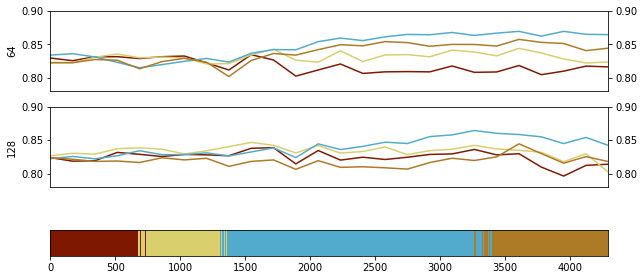

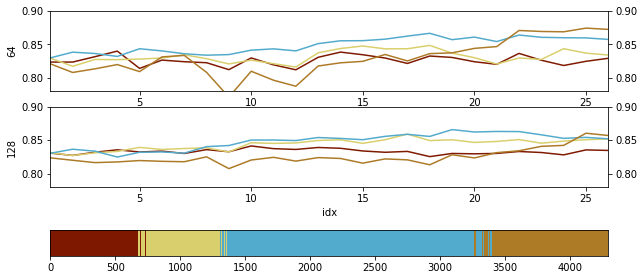

In [27]:
hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'noncontinuous_steps': 3000,
         'noncontinuous_train_splits': ['train', 'base_train'],
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
memorymaximas = [64, 128]
#hparams['stylemodel'] = True

fig, axes = plt.subplots(3, 1, figsize=(10, 5))

for i, mm in enumerate(memorymaximas):
    hparams['memorymaximum'] = mm
    df, df_mem = res_data_for_params(hparams)

    ax = axes[i]
    sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
    sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
    sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
    sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
    ax.set_ylim(0.78, 0.90)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    ax.set_xlim(1, 26)
    ax.set_ylabel(f'{mm}')
    ax.tick_params(labelright=True, right=True)


axes[2].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[2].get_yaxis().set_visible(False)
axes[2].get_yaxis()

hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
memorymaximas = [64, 128]

fig, axes = plt.subplots(3, 1, figsize=(10, 5))
hparams['stylemodel'] = True
for i, mm in enumerate(memorymaximas):
    hparams['memorymaximum'] = mm
    df, df_mem = res_data_for_params(hparams)

    ax = axes[i]
    sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
    sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
    sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
    sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
    ax.set_ylim(0.78, 0.9)
    ax.set_xlim(1, 26)
    ax.set_ylabel(f'{mm}')
    ax.get_legend().remove()
    ax.tick_params(labelright=True, right=True)



axes[2].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[2].get_yaxis().set_visible(False)
axes[2].get_yaxis()

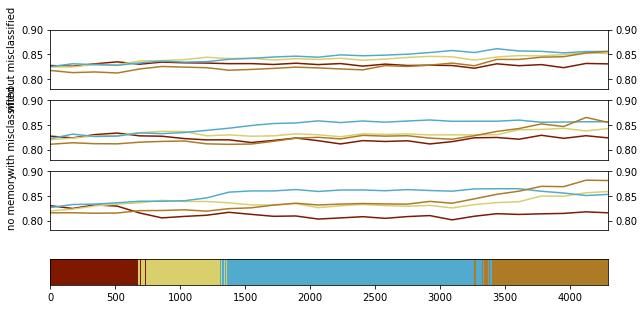

In [24]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 5,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 132054,
         'stylemodel': True
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

fig, axes = plt.subplots(4, 1, figsize=(10, 5))

df = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'without misclassified')
ax.tick_params(labelright=True, right=True)

hparams['force_misclassified'] = True
hparams['misclass_threshold'] = 0.80

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[1]
sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'with misclassified')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[2]
sns.lineplot(data=df, y='val_dice1_Siemens', x='idx', err_style=None, ax=ax, label='Siemens')
sns.lineplot(data=df, y='val_dice1_GE', x='idx', err_style=None, ax=ax, label='GE')
sns.lineplot(data=df, y='val_dice1_Philips', x='idx', err_style=None, ax=ax, label='Philips')
sns.lineplot(data=df, y='val_dice1_Canon', x='idx', err_style=None, ax=ax, label='Canon')
ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'no memory')
ax.tick_params(labelright=True, right=True)


axes[3].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()

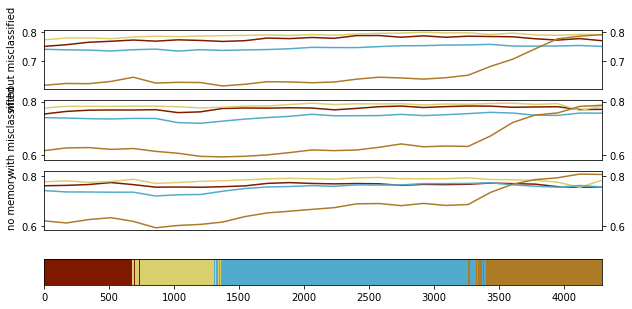

In [20]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

val_measure = 'val_dice3'


hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 5,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 132054,
         'stylemodel': True
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

fig, axes = plt.subplots(4, 1, figsize=(10, 5))

df = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'without misclassified')
ax.tick_params(labelright=True, right=True)

hparams['force_misclassified'] = True
hparams['misclass_threshold'] = 0.8

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[1]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'with misclassified')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[2]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'no memory')
ax.tick_params(labelright=True, right=True)


axes[3].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()

cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_5f7a07df57
{'root_dir': '/project/catinous/', 'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv', 'batch_size': 16, 'training_batch_size': 16, 'transition_phase_after': 0.8, 'memorymaximum': 128, 'use_memory': True, 'random_memory': True, 'balance_memory': False, 'order': ['Siemens', 'GE', 'Philips', 'Canon'], 'continuous': True, 'noncontinuous_steps': 3000, 'noncontinuous_train_splits': ['train', 'base_train'], 'val_check_interval': 10, 'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', 'run_postfix': 1, 'dim': 2, 'task': 'cardiac', 'model': 'fcn', 'seed': 1654130, 'stylemodel': True}
cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_0cd485ee41
{'root_dir': '/project/catinous/', 'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv', 'batch_size': 16, 'training_batch_size': 16, 'transition_phase_after': 0.8, 'memorymaximum': 128, 'use_memory': True, 'random_m

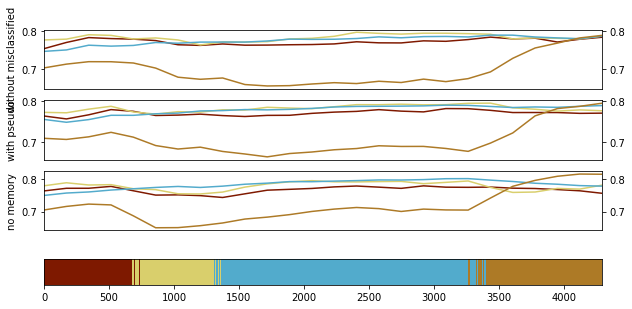

In [21]:
seeds = [1654130, 6654961, 5819225, 1215862, 132054]

val_measure = 'val_dice3'

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         #'force_misclassified': True,
         #'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }


hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)

fig, axes = plt.subplots(4, 1, figsize=(10, 5))

df = res_data_for_params(hparams, seeds=seeds)

ax = axes[0]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'without misclassified')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', # cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True,
         'pseudodomain_detection': True
        }

#hparams['force_misclassified'] = True
#hparams['misclass_threshold'] = 0.80
df = res_data_for_params(hparams, seeds=seeds)

ax = axes[1]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'with pseudo')
ax.tick_params(labelright=True, right=True)

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':False,
         'random_memory': True,
         'balance_memory': False,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt',#'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130
        }

df = res_data_for_params(hparams, seeds=seeds)
ax = axes[2]
for scanner in hparams['order']:
    sns.lineplot(data=df, y=f'{val_measure}_{scanner}', x='idx', err_style=None, ax=ax, label=scanner)
#ax.set_ylim(0.78, 0.90)
ax.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_xlim(1, 26)
ax.set_ylabel(f'no memory')
ax.tick_params(labelright=True, right=True)


axes[3].imshow(np.tile(res,(200,1)), cmap=ListedColormap(colormap.colors[:4]))
axes[3].get_yaxis().set_visible(False)
axes[3].get_yaxis()

In [3]:
hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         #'force_misclassified': True,
         #'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }
dmodel.cached_path(hparams)

'/project/catinous/trained_models/cardiac_cont_cardiacslicessplitsingle_basemodel_batch_mem_tf08_1_5f7a07df57.pt'

In [57]:

hparams={'root_dir':'/project/catinous/',
         'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
         'batch_size': 16,
         'training_batch_size': 16,
         'transition_phase_after':0.8,
         'memorymaximum': 128,
         'use_memory':True,
         'random_memory': True,
         'balance_memory': False,
         'force_misclassified': True,
         'misclass_threshold': 0.8,
         'order': ['Siemens', 'GE', 'Philips', 'Canon'],
         'continuous': True,
         'val_check_interval': 10,
        'base_model': 'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1.pt', #'cardiac_batch_cardiacslicessplit_base_1_7826e2e7a0.pt',
        'run_postfix': 1,
        'gram_weights': [1, 1, 1, 1],
        'dim': 2,
         'task': 'cardiac',
         'model': 'fcn',
         'seed': 1654130,
         'stylemodel': True
        }

#hparams['force_misclassified'] = True
#hparams['misclass_threshold'] = 0.80

hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)
df_means = pd.DataFrame()
for i, seed in enumerate(seeds):
    hparams['seed'] = seed
    hparams['run_postfix'] = i+1

    df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
    df_means = df_means.append(df.groupby('scanner').mean().reset_index())

In [48]:
#pseudodomains
df_pseudo = df_means.groupby('scanner').mean()
df_pseudo['mean'] = df_pseudo.mean(axis=1)
df_pseudo

,dice_1,dice_2,dice_3,mean
scanner,,,,
Canon,0.861110,0.792432,0.803610,0.819051
GE,0.790828,0.704534,0.775889,0.757084
Philips,0.827687,0.761834,0.808402,0.799308
Siemens,0.835328,0.735854,0.784397,0.785193


In [51]:
#naive
df_naive = df_means.groupby('scanner').mean()
df_naive['mean'] = df_naive.mean(axis=1)
df_naive

,dice_1,dice_2,dice_3,mean
scanner,,,,
Canon,0.885481,0.815017,0.819175,0.839891
GE,0.771829,0.686865,0.753512,0.737402
Philips,0.826380,0.749228,0.794756,0.790121
Siemens,0.842093,0.734176,0.763787,0.780019


In [52]:
#wo force
df_wo_force = df_means.groupby('scanner').mean()
df_wo_force['mean'] = df_wo_force.mean(axis=1)
df_wo_force

,dice_1,dice_2,dice_3,mean
scanner,,,,
Canon,0.863553,0.789550,0.803136,0.818746
GE,0.791026,0.707552,0.791599,0.763393
Philips,0.830323,0.765966,0.807227,0.801172
Siemens,0.843996,0.747222,0.787763,0.792994


In [55]:
#with force
df_w_force = df_means.groupby('scanner').mean()
df_w_force['mean'] = df_w_force.mean(axis=1)
df_w_force

,dice_1,dice_2,dice_3,mean
scanner,,,,
Canon,0.877382,0.803561,0.818148,0.833030
GE,0.778488,0.688246,0.788737,0.751823
Philips,0.825495,0.759440,0.808280,0.797738
Siemens,0.844836,0.737712,0.799654,0.794067


In [56]:
hparams = {
    'continuous': False,
    'datasetfile': '/project/catinous/cardiacslicessplitsingle.csv',
    'batch_size': 16,
    'training_batch_size': 16,
    'task': 'cardiac',
    'model': 'fcn',
    'scanner': 'Siemens',
     'noncontinuous_steps': 1000,
    'noncontinuous_train_splits': ['base'],
    'use_memory': False
}
hparams = cutils.default_params(DynamicMemoryModel.get_default_hparams(), hparams)


df = pd.read_csv(f'/project/catinous/results/cardiac/{cutils.get_expname(hparams)}_dicescores.csv')
df.groupby('scanner').mean().reset_index()

,scanner,dice_1,dice_2,dice_3
0,Canon,0.779936,0.657816,0.725421
1,GE,0.796982,0.716649,0.773945
2,Philips,0.827131,0.726562,0.791815
3,Siemens,0.838756,0.756844,0.796143


In [7]:
cutils.get_expname(hparams)

'cardiac_batch_cardiacslicessplitsingle_base_1_ebc3df72a1'

In [67]:
df.loc[df.dice_1!=0.0].groupby('scanner').mean().reset_index()

,scanner,dice_1,dice_2,dice_3
0,Canon,0.935045,0.837503,0.815515
1,GE,0.889269,0.772311,0.793555
2,Philips,0.898179,0.797353,0.803663
3,Siemens,0.915688,0.783075,0.776653


In [64]:
df.groupby('scanner').mean().reset_index()

,scanner,dice_1,dice_2,dice_3
0,Canon,0.864545,0.801672,0.821488
1,GE,0.766362,0.679002,0.786770
2,Philips,0.823331,0.752629,0.809639
3,Siemens,0.835364,0.725945,0.791859
